## Packages

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matROOT_DIRECTORYROOT_DIRECTORYplotlib import pyplot as plt
from matplotlib.pyplot import figure
from warnings import filterwarnings
from pprint import pprint
filterwarnings("ignore")
%matplotlib inline

## Global Parameters

In [2]:
ROOT_DIRECTORY = "/home/kaan.aytekin/Thesis"
#ROOT_DIRECTORY = "/Users/kaan.aytekin/Desktop/Kaan/Thesis"
SIMULATION_DURATION = 90 * 60 #Seconds
WARM_UP_PERIOD_DURATION = 15 * 60 #Seconds
COOL_DOWN_PERIOD_DURATION = 15 * 60 #Seconds
DETECTOR_SEPARATION_DISTANCE = 500 #Meter
DETECTOR_COUNT = 21
TOTAL_ROAD_LENGTH = DETECTOR_COUNT * DETECTOR_SEPARATION_DISTANCE

## UDFs

In [3]:
def timeit(func):
    """Wrapper function for logging the function duration

    Args:
        func (function): Function to measure performance

    Returns:
        function: Function with performance measurement capabilities
    """
    from functools import wraps
    import datetime as dt
    @wraps(func)
    def timed(*args, **kwargs):
        function_name = func.__name__
        start_time = dt.datetime.now()
        result = func(*args, **kwargs)
        end_time = dt.datetime.now()
        execution_duration = (end_time - start_time).total_seconds()
        print(
            f"Function {function_name!r} executed in {execution_duration:.4f} seconds ({execution_duration/60:.2f} minutes)")
        return result
    return timed

def calculate_section_travel_time(speed_kilometer_per_second):
    speed_meter_per_second = speed_kilometer_per_second * (1000 / (60 * 60))
    if speed_meter_per_second:
        travel_time_sec = DETECTOR_SEPARATION_DISTANCE / speed_meter_per_second
        return travel_time_sec

def calculate_time_after_accident_start(df_row):
    if df_row.is_accident_timestamp:
        return float(df_row.timestamp - df_row.accident_start_time)
    else:
        return 0

def calculate_distance_to_accident(df_row):
    if df_row.is_accident_timestamp:
        return float(
            df_row.accident_location
            - df_row.detector_number * DETECTOR_SEPARATION_DISTANCE
        )
    else:
        return 9999999#np.Inf

@timeit
def calculate_detector_lag_values(df, max_lag=10):
    simulation_config_columns = [
        "simulation_run",
        "accident_location",
        "accident_start_time",
        "accident_duration",
        "accident_lane",
        "detector_number",
    ]
    traffic_metrics = [
        "flow_vehph",
        "density_vehpkm",
        "avg_speed_kmph",
        "section_travel_time_sec",
        "delay_time_sec",
    ]
    df_sorted = df.sort_values(simulation_config_columns + ["timestamp"])
    for lag_number in range(max_lag):
        lag_number += 1
        lagged_features = [
            f"flow_vehph_lag{lag_number}",
            f"density_vehpkm_lag{lag_number}",
            f"avg_speed_kmph_lag{lag_number}",
            f"section_travel_time_sec_lag{lag_number}",
            f"delay_time_sec_lag{lag_number}",
        ]
        df_sorted[lagged_features] = df_sorted.groupby(by=simulation_config_columns)[
            traffic_metrics
        ].shift(lag_number)
    return df_sorted


@timeit
def calculate_adjacent_detector_features(df):
    def key_mapper(key):
        if "_next_detector" in key:
            new_key = key.replace("_next_detector", "")
            new_key = "next_detector_" + new_key
        elif "_prev_detector" in key:
            new_key = key.replace("_prev_detector", "")
            new_key = "prev_detector_" + new_key
        else:
            new_key = key
        return new_key

    merging_columns = [
        "simulation_run",
        "accident_location",
        "accident_start_time",
        "accident_duration",
        "accident_lane",
        "timestamp",
        "detector_number",
    ]
    simulation_metrics = [
        "flow_vehph",
        "density_vehpkm",
        "avg_speed_kmph",
        "section_travel_time_sec",
        "delay_time_sec",
    ]
    simulation_metrics_with_lags = simulation_metrics.copy()
    max_lag = 10
    for lag_number in range(max_lag):
        lag_number += 1
        simulation_metrics_with_lags = simulation_metrics_with_lags + [
            f"{metric}_lag{lag_number}" for metric in simulation_metrics
        ]

    df["next_detector_number"] = df["detector_number"] + 1
    df["prev_detector_number"] = df["detector_number"] - 1

    df_merged = df.merge(
        df[merging_columns + simulation_metrics_with_lags],
        how="left",
        left_on=merging_columns[:-1] + ["next_detector_number"],
        right_on=merging_columns,
        suffixes=("", "_next_detector"),
    )
    df_merged = df_merged.merge(
        df[merging_columns + simulation_metrics_with_lags],
        how="left",
        left_on=merging_columns[:-1] + ["prev_detector_number"],
        right_on=merging_columns,
        suffixes=("", "_prev_detector"),
    )
    df_merged = df_merged.drop(["next_detector_number", "prev_detector_number"], axis=1)

    df_merged = df_merged.rename(columns=key_mapper)
    return df_merged

@timeit
def calculate_target_value(df):
    simulation_config_columns = [
        "simulation_run",
        "accident_location",
        "accident_start_time",
        "accident_duration",
        "accident_lane",
        "detector_number",
    ]
    df_sorted = df.sort_values(simulation_config_columns + ["timestamp"])
    target_delay_time = df_sorted.groupby(by=simulation_config_columns)[
        "delay_time_sec"
    ].shift(-1)
    return target_delay_time

@timeit
def plot_detector_timelines(df, detector_metric, detector_numbers, simulation_configs):
    detector_metric_name_map = {
        "flow_vehph": "Flow(Veh/Hr)",
        "density_vehpkm": "Density(Veh/Km)",
        "avg_speed_kmph": "Speed(Km/Hr)",
        "section_travel_time_sec": "Travel Time(Sec)",
        "delay_time_sec": "Delay Time(Sec)",
    }
    detector_metric_name = detector_metric_name_map[detector_metric]
    # Data Filtering
    simulation_selector = None
    for key, value in simulation_configs.items():
        if simulation_selector is not None:
            simulation_selector = (simulation_selector) & (df[key] == value)
        else:
            simulation_selector = df[key] == value
    detector_selector = None
    for detector in detector_numbers:
        if detector_selector is not None:
            detector_selector = (detector_selector) | (
                df["detector_number"] == detector
            )
        else:
            detector_selector = df["detector_number"] == detector
    plotting_columns = {
        "x": "timestamp",
        "y": detector_metric,
        "hue": "detector_number",
        # "style":"detector_number"
    }
    plotting_df = df[simulation_selector & detector_selector][
        list(set(plotting_columns.values()))
    ]
    # Plotting helpers
    max_metric_point = plotting_df[detector_metric].max()
    detector_numbers_str = f"{detector_numbers}".strip("[]")
    accident_start_time = simulation_configs["accident_start_time"]
    accident_duration = simulation_configs["accident_duration"]
    accident_detector = int(
        np.ceil(simulation_configs["accident_location"] / DETECTOR_SEPARATION_DISTANCE)
    )
    title = f"{detector_metric_name.split('(')[0]} distribution for Detector(s) {detector_numbers_str}\n Accident Configs: {simulation_configs}\nAccident in detector {accident_detector}"
    # Plotting
    figure(num=None, figsize=(20, 12), dpi=80, facecolor="w", edgecolor="k")
    # ax = sns.lineplot(data=plotting_df,palette=sns.color_palette("Spectral",len(detector_numbers)),**plotting_columns)
    ax = sns.lineplot(
        data=plotting_df,
        palette=sns.color_palette("husl", len(detector_numbers)),
        **plotting_columns,
    )
    ax.set(title=title, xlabel="Timestamp(sec)", ylabel=detector_metric_name)
    plt.vlines(
        x=accident_start_time,
        ymin=0,
        ymax=max_metric_point,
        colors="blue",
        linewidths=3,
    )
    plt.vlines(
        x=accident_start_time + accident_duration,
        ymin=0,
        ymax=max_metric_point,
        colors="blue",
        linewidths=3,
    )
    plt.show()

## Data Preperations

In [4]:

aggreagated_data_path = os.path.join(ROOT_DIRECTORY,"data/thesis_data/aggreagated_simulation_data.csv")
complete_df = pd.read_csv(aggreagated_data_path)
#Rename columns
complete_df = complete_df.rename(columns = {
    "avg_speed":"avg_speed_kmph",
    "density": "density_vehpkm",
    "flow": "flow_vehph"
}
)
#Calculate avg. travel times between detectors based on the detector separation distance and avg. speed
complete_df["section_travel_time_sec"] = complete_df["avg_speed_kmph"].apply(calculate_section_travel_time)

#Remove accident simulations & warm-up & cool-down periods to get free flow speed
no_accident_warm_up_df = complete_df[
    (WARM_UP_PERIOD_DURATION < complete_df.timestamp) #First 15 minutes
    & (complete_df.timestamp < SIMULATION_DURATION - COOL_DOWN_PERIOD_DURATION) #Last 15 minutes
    & (complete_df.accident_duration==0)
    & (~complete_df.section_travel_time_sec.isna())
]
freeflow_section_travel_time_sec = no_accident_warm_up_df["section_travel_time_sec"].min()

complete_df["delay_time_sec"] = complete_df["section_travel_time_sec"] - freeflow_section_travel_time_sec

#Remove warm-up periods
df = complete_df[
    (WARM_UP_PERIOD_DURATION < complete_df.timestamp) #First 15 minutes
    & (complete_df.timestamp < SIMULATION_DURATION - COOL_DOWN_PERIOD_DURATION) #Last 15 minutes
]
df = df.reset_index(drop=True)

In [ ]:
df.head()

## Natural Mean Delay Distribution Plot

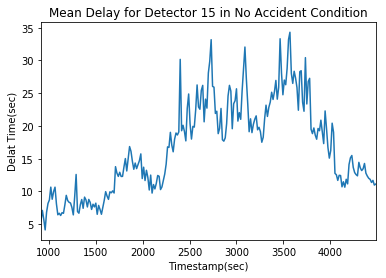

In [5]:
#Check mean delay for NO_ACCIDENT-DECETOR_15
ax = df[
    (df.accident_location == 0)
    & (df.detector_number == 15)
].groupby("timestamp")["delay_time_sec"].mean().plot()
ax.set(title="Mean Delay for Detector 15 in No Accident Condition",xlabel='Timestamp(sec)', ylabel='Delat Time(sec)')
plt.show()

In [ ]:
#Check mean delay distribution for NO_ACCIDENT-DECETOR_15
plotting_df = df[
    (df.accident_location == 0)
    & (df.detector_number == 15)
][["timestamp","delay_time_sec"]]
ax = sns.lineplot(data=plotting_df,x="timestamp",y="delay_time_sec")
ax.set(title="Delay distribution for Detector 15 in No Accident Condition",xlabel='Timestamp(sec)', ylabel='Delat Time(sec)')
plt.show()

### Accident Simulation Plot

In [ ]:
df[
    (df.is_accident_simulation == 1)
    & (df.accident_lane == 3)
][
    [
    "is_accident_simulation",
    "accident_location",
    "accident_start_time",
    "accident_duration",
    "accident_lane",]
].drop_duplicates()

In [ ]:
simulation_configs = {
    "is_accident_simulation" : 1,
    "accident_location" : 6932,
    "accident_start_time" : 2681,
    "accident_duration" : 1245,
    "accident_lane" : 1,
}
detector_numbers = [12,13,14,15]
plot_detector_timelines(df=df,detector_metric="delay_time_sec",detector_numbers=detector_numbers,simulation_configs=simulation_configs)

In [ ]:
simulation_configs = {
    "is_accident_simulation" : 1,
    "accident_location" : 6108,
    "accident_start_time" : 1427,
    "accident_duration" : 1093,
    "accident_lane" : 3,
}
detector_numbers = [10,11,12,13,14]
plot_detector_timelines(df=df,detector_metric="delay_time_sec",detector_numbers=detector_numbers,simulation_configs=simulation_configs)


In [ ]:
simulation_configs = {
    "is_accident_simulation" : 1,
    "accident_location" : 5001,
    "accident_start_time" : 1248,
    "accident_duration" : 1238,
    "accident_lane" : 3,
}
detector_numbers = [9,10,11,12]
plot_detector_timelines(df=df,detector_metric="delay_time_sec",detector_numbers=detector_numbers,simulation_configs=simulation_configs)

In [ ]:
plot_detector_timelines(df=df,detector_metric="flow_vehph",detector_numbers=detector_numbers,simulation_configs=simulation_configs)

In [ ]:
plot_detector_timelines(df=df,detector_metric="avg_speed_kmph",detector_numbers=detector_numbers,simulation_configs=simulation_configs)

In [ ]:
plot_detector_timelines(df=df,detector_metric="density_vehpkm",detector_numbers=detector_numbers,simulation_configs=simulation_configs)

### Remark
**Different accident lanes effect different road sections**<br>
Example:<br>
- Accident in detector 11-lane 3 affects detectors 9 & 10 more than 11 & 12
- Accident in detector 14-lane 1 affects detector 14 more than any other

## Feature Engineering

In [ ]:
# Calculate lag values for flow_vehph, density_vehpkm, avg_speed_kmph, section_travel_time_sec & delay_time_sec
df = calculate_detector_lag_values(df,max_lag=10)
# Add features of previous & next detectors
df = calculate_adjacent_detector_features(df)
# Calculate time after accident
df["time_after_accident_started"] = df.apply(calculate_time_after_accident_start,axis=1)
# Calculate detector distance to incident
df["distance_to_accident"] = df.apply(calculate_distance_to_accident,axis=1)
# Calculate target (next time step) delay time
df["target_delay_time"] = calculate_target_value(df)

In [ ]:
df.head()

In [ ]:
#Check lagged features
simulation_timestamp_selector = (
            (df.simulation_run == 0)
            & (df.accident_location == 0)
            & (df.accident_start_time == 0)
            & (df.accident_duration == 0)
            & (df.accident_lane == 0)
            & ((df.detector_number == 3))
        )
df[
 simulation_timestamp_selector   
].sort_values(["timestamp","detector_number"]).iloc[:9][["detector_number","timestamp","delay_time_sec","delay_time_sec_lag1","delay_time_sec_lag2","target_delay_time"]]

In [ ]:
#Check adjacent features
simulation_timestamp_selector = (
            (df.simulation_run == 0)
            & (df.accident_location == 0)
            & (df.accident_start_time == 0)
            & (df.accident_duration == 0)
            & (df.accident_lane == 0)
            & ((df.detector_number == 2)| (df.detector_number == 3)  | (df.detector_number == 4))
        )
df[
 simulation_timestamp_selector   
].sort_values(["timestamp","detector_number"]).iloc[:9][["detector_number","timestamp","delay_time_sec","prev_detector_delay_time_sec","next_detector_delay_time_sec","delay_time_sec_lag1","next_detector_delay_time_sec_lag1","prev_detector_delay_time_sec_lag1"]]

In [ ]:
#All features
pprint(list(df.columns),width=200,compact=True)

In [ ]:
df_na_columns = list(df.columns[df.isna().any()])

In [ ]:
df.isna().sum().sum() #5_243_055

In [ ]:
%time
# Backfilling for NAs in lagged features
df_backfilled = df.copy()
df_backfilled.update(df.groupby(
    [
        "simulation_run",
        "accident_location",
        "accident_start_time",
        "accident_duration",
        "accident_lane",
        "detector_number",
    ]
).fillna(method = "backfill"))

In [ ]:
df_backfilled_na_columns = list(df_backfilled.columns[df_backfilled.isna().any()])

In [ ]:
set(df_na_columns).difference(set(df_backfilled_na_columns))

In [ ]:
df_backfilled.isna().sum().sum() #3_214_726

In [ ]:
# Filling NAs in boundary detectors
column_list = list(df_backfilled.columns)
previous_detector_columns = []
next_detector_columns = []
current_detector_columns = []
for column_name in column_list:
    if "prev_detector_" in column_name:
        previous_detector_columns.append(column_name)
        original_column_name = column_name.replace("prev_detector_","")
        current_detector_columns.append(original_column_name)
        next_column_name = column_name.replace("prev_detector_","next_detector_")
        next_detector_columns.append(next_column_name)

df_backfilled_boundary_filled = df_backfilled.copy()
for previous_detector_column_name,current_detector_column_name in zip(previous_detector_columns,current_detector_columns):
    df_backfilled_boundary_filled[previous_detector_column_name][(df_backfilled_boundary_filled.detector_number == 1)] = df_backfilled_boundary_filled[current_detector_column_name][(df_backfilled_boundary_filled.detector_number == 1)]

for next_detector_column_name,current_detector_column_name in zip(next_detector_columns,current_detector_columns):
    df_backfilled_boundary_filled[next_detector_column_name][(df_backfilled_boundary_filled.detector_number == 21)] = df_backfilled_boundary_filled[current_detector_column_name][(df_backfilled_boundary_filled.detector_number == 21)]

# Drop last timestamps
df_backfilled_boundary_filled = df_backfilled_boundary_filled.dropna(subset=["target_delay_time"])

In [ ]:
# Check for NAs
df_backfilled_boundary_filled.isna().sum().sum() #0

In [ ]:
df_backfilled_boundary_filled.head()

In [ ]:
df_final = df_backfilled_boundary_filled.copy()
feature_engineered_data_path = os.path.join(ROOT_DIRECTORY,"data/thesis_data/feature_engineered_data.csv")
df_final.to_csv(feature_engineered_data_path,index=False)